In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/lexicons.zip'

Archive:  /content/drive/MyDrive/lexicons.zip
replace lexicons/ta.translit.sampled.test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: lexicons/ta.translit.sampled.test.tsv  
  inflating: lexicons/ta.translit.sampled.dev.tsv  
  inflating: lexicons/ta.translit.sampled.train.tsv  


In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: kodikarthik21 (use `wandb login --relogin` to force relogin)


True

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from wandb.keras import WandbCallback
import tensorflow_addons as tfa
from math import log

In [ ]:
train_df = pd.read_csv("/content/lexicons/ta.translit.sampled.train.tsv", sep = '\t', header = None)
train_df = train_df.dropna(axis=0)

val_df = pd.read_csv("/content/lexicons/ta.translit.sampled.dev.tsv", sep = '\t', header = None)
val_df = val_df.dropna(axis=0)

test_df = pd.read_csv("/content/lexicons/ta.translit.sampled.test.tsv", sep = '\t', header = None)
test_df = test_df.dropna(axis=0)


In [ ]:
train_df

,0,1,2
0,ஃபியட்,fiat,2
1,ஃபியட்,phiyat,1
2,ஃபியட்,piyat,1
3,ஃபிரான்ஸ்,firaans,1
4,ஃபிரான்ஸ்,france,2
...,...,...,...
68213,ஹோல்ட்,holtt,1
68214,ஹோல்ட்,hoold,1
68215,ஹோல்ட்,hoolt,1
68216,ஹோல்ட்,hooltt,1


In [ ]:
val_df.shape

(6827, 3)

In [ ]:
val_df[0][3]

'ஃபார்'

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
for input_text,target_text in zip(train_df[1][0:],train_df[0][0:]):
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
pred_target_token_index = dict([(i, char) for i, char in enumerate(target_characters)])

if ' ' not in input_token_index:
  input_token_index[' '] = len(input_token_index)

if ' ' not in target_token_index:
  target_token_index[' '] = len(target_token_index)

pred_target_token_index[len(pred_target_token_index)] = ' '


num_encoder_tokens = len(input_characters) + 1
num_decoder_tokens = len(target_characters) + 1
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t] = input_token_index[char]
    encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :] = target_token_index[" "]
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Number of samples: 68215
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28


In [ ]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 48,
 'ஃ': 2,
 'அ': 3,
 'ஆ': 4,
 'இ': 5,
 'ஈ': 6,
 'உ': 7,
 'ஊ': 8,
 'எ': 9,
 'ஏ': 10,
 'ஐ': 11,
 'ஒ': 12,
 'ஓ': 13,
 'க': 14,
 'ங': 15,
 'ச': 16,
 'ஜ': 17,
 'ஞ': 18,
 'ட': 19,
 'ண': 20,
 'த': 21,
 'ந': 22,
 'ன': 23,
 'ப': 24,
 'ம': 25,
 'ய': 26,
 'ர': 27,
 'ற': 28,
 'ல': 29,
 'ள': 30,
 'ழ': 31,
 'வ': 32,
 'ஷ': 33,
 'ஸ': 34,
 'ஹ': 35,
 'ா': 36,
 'ி': 37,
 'ீ': 38,
 'ு': 39,
 'ூ': 40,
 'ெ': 41,
 'ே': 42,
 'ை': 43,
 'ொ': 44,
 'ோ': 45,
 'ௌ': 46,
 '்': 47}

In [ ]:
# Vectorize the data.
val_input_texts = []
val_target_texts = []

for val_input_text,val_target_text in zip(val_df[1][0:],val_df[0][0:]):
    val_target_text = "\t" + val_target_text + "\n"
    val_input_texts.append(val_input_text)
    val_target_texts.append(val_target_text)

val_encoder_input_data = np.zeros(
    (len(val_input_texts), max_encoder_seq_length), dtype="float32"
)
val_decoder_input_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length), dtype="float32"
)
val_decoder_target_data = np.zeros(
    (len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t] = input_token_index[char]
    val_encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :] = target_token_index[" "]
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
# Vectorize the data.
test_input_texts = []
test_target_texts = []

for test_input_text,test_target_text in zip(test_df[1][0:],test_df[0][0:]):
    test_target_text = "\t" + test_target_text + "\n"
    test_input_texts.append(test_input_text)
    test_target_texts.append(test_target_text)

test_encoder_input_data = np.zeros(
    (len(test_input_texts), max_encoder_seq_length), dtype="float32"
)
test_decoder_input_data = np.zeros(
    (len(test_input_texts), max_decoder_seq_length), dtype="float32"
)
test_decoder_target_data = np.zeros(
    (len(test_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(test_input_texts, test_target_texts)):
    for t, char in enumerate(input_text):
        test_encoder_input_data[i, t] = input_token_index[char]
    test_encoder_input_data[i, t + 1 :] = input_token_index[" "]
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        test_decoder_input_data[i, t] = target_token_index[char]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            test_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    test_decoder_input_data[i, t + 1 :] = target_token_index[" "]
    test_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
# # Define sampling models
# # Restore the model and construct the encoder and decoder.
# def encoder(model,num_enc_layers):
#   # Define sampling models
#   # Restore the model and construct the encoder and decoder.
#   encoder_inputs = model.input[0]  # input_1
#   encoder_seq,state_h_enc, state_c_enc = model.get_layer('encoder_'+str(num_enc_layers)).output  # lstm_2
#   encoder_states = [state_h_enc, state_c_enc]
#   encoder_model = keras.Model(encoder_inputs, encoder_states)
#   return encoder_model

# def decoder(model, num_dec_layers,latent_dim):
#   decoder_inputs = decoder_inputs = keras.Input(shape=(1,), name="input_2")   # input_2
#   decoder_embed = model.get_layer('embedding_2')
#   decoder_input = decoder_embed(decoder_inputs)

#   decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
#   decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
#   decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

#   decoder_lstm_1 = model.get_layer('decoder_1')
#   decoder_outputs, state_h_dec, state_c_dec = decoder_lstm_1(
#       decoder_input, initial_state=decoder_states_inputs
#   )

#   decoder_states = [state_h_dec, state_c_dec]
#   for i in range(num_dec_layers-2):
#     decoder_outputs, state_h_dec, state_c_dec = model.get_layer('decoder_'+str(i+2))(
#         decoder_outputs,initial_state=decoder_states_inputs
#     )
#   decoder_states = [state_h_dec, state_c_dec]

#   decoder_dense = model.get_layer('time_distributed')
#   decoder_outputs = decoder_dense(decoder_outputs)
#   decoder_model = keras.Model(
#       [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
#   )

#   return decoder_model

In [ ]:

# def decode_sequence(input_seq,model,num_enc_layers,num_dec_layers,hidden_layers):
#     # Encode the input as state vectors.
#     encoder_model = encoder(model,num_enc_layers)
#     decoder_model = decoder(model, num_dec_layers, hidden_layers)
#     states_value = encoder_model.predict(input_seq)

#     # Generate empty target sequence of length 1.
#     target_seq = np.zeros((1, 1))
#     # Populate the first character of target sequence with the start character.
#     target_seq[0, 0] = target_token_index["\t"]

#     # Sampling loop for a batch of sequences
#     # (to simplify, here we assume a batch of size 1).
#     stop_condition = False
#     decoded_sentence = ""
#     while not stop_condition:
#         output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
#         # Sample a token
#         sampled_token_index = np.argmax(output_tokens[0, -1, :])
#         sampled_char = pred_target_token_index[sampled_token_index]
#         decoded_sentence += sampled_char

#         # Exit condition: either hit max length
#         # or find stop character.
#         if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
#             stop_condition = True

#         # Update the target sequence (of length 1).
#         target_seq = np.zeros((1, 1))
#         target_seq[0, 0] = sampled_token_index

#         # Update states
#         states_value = [h, c]
#         decoded_sentence = decoded_sentence.strip('\n')
#     return decoded_sentence

In [ ]:
def rnnmodel(cell_name, embedding_size, hidden_size, num_enc_layers, num_dec_layers, dropout, r_dropout, batch_size, num_epochs, optimizer):
  
  cell_type = { "RNN": keras.layers.SimpleRNN,
                "GRU": keras.layers.GRU,
                "LSTM": keras.layers.LSTM
  }

  learning_rate = 0.01
  decay_rate = 0

  optimizers = {"adam": tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate),
                "nadam": tf.keras.optimizers.Nadam(lr=learning_rate, decay=decay_rate),
                "rmsprop": tf.keras.optimizers.RMSprop(lr=learning_rate, decay=decay_rate),
                "adagrad": tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
  }

  # Define an input sequence and process it.
  encoder_inputs = keras.layers.Input(shape=(None,), name="input_1")
  embedding = keras.layers.Embedding(num_encoder_tokens, embedding_size, name="embedding_1")(encoder_inputs)
  encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_1")(embedding)
  for i in range(1, num_enc_layers):
    encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_"+str(i+1), dropout=dropout,
                                                       recurrent_dropout=r_dropout)(encoder_seq)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = keras.layers.Input(shape=(None,), name="input_2")
  decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size, name="embedding_2")(decoder_inputs)

  # We set up our decoder to return full output sequences,
  # and to return internal states as well. We don't use the
  # return states in the training model, but we will use them in inference.
  decoder_seq, *_ = cell_type[cell_name](hidden_size,return_sequences=True, return_state=True, name="decoder_1")(decoder_embedding,initial_state=encoder_state)
  for i in range(1, num_dec_layers):
    decoder_seq, *_ = cell_type[cell_name](hidden_size, return_sequences=True, return_state=True, name="decoder_"+str(i+1),dropout=dropout,
                                      recurrent_dropout=r_dropout)(decoder_seq,initial_state=encoder_state)

  decoder_outputs = keras.layers.TimeDistributed(keras.layers.Dense(num_decoder_tokens, activation="softmax"),name = 'time_distributed')(decoder_seq)
  #decoder_outputs = keras.layers.Dense(num_decoder_tokens, activation="softmax", name="dense_1")(decoder_seq)


  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(
    optimizer=optimizers[optimizer], loss="categorical_crossentropy", metrics=["accuracy"]
  )
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=([val_encoder_input_data, val_decoder_input_data],
                      val_decoder_target_data),
      callbacks=[WandbCallback()]
  )
  acc = model.history.history['val_accuracy'][num_epochs-1]
  return model,acc

In [ ]:
def decode_sequence(input_seq,encoder_model,decoder_model):
    # Encode the input as state vectors.
    #print(input_seq)
    states_value = encoder_model.predict([input_seq])
    #print(len(states_value))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        #print([target_seq] + states_value)
        output_tokens, *decoder_states = decoder_model.predict([target_seq, states_value])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = decoder_states
        #print(len(decoded_sentence))
    decoded_sentence = decoded_sentence.strip('\n')
    decoded_sentence = decoded_sentence.strip(' ')
    return decoded_sentence


def calc_val_acc(model,config):

  # Define sampling models
  # Restore the model and construct the encoder and decoder.
  latent_dim = config.hidden_size
  encoder_inputs = model.input[0]  # input_1
  encoder_seq,*encoder_states  = model.get_layer('encoder_{}'.format(config.num_enc_layers)).output
  #encoder_seq,state_h_enc, state_c_enc = encoder_lstm2(encoder_seq)  # lstm_
  encoder_model = keras.Model(encoder_inputs, encoder_states)


  decoder_inputs = keras.layers.Input(shape=(1,), name="input_2") # input_2
  decoder_embed = model.get_layer('embedding_2')
  decoder_input = decoder_embed(decoder_inputs)

  if(config.cell_name == 'LSTM'):
    decoder_state_input_h = keras.layers.Input(shape=(latent_dim,), name="input_3")
    decoder_state_input_c = keras.layers.Input(shape=(latent_dim,), name="input_4")
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
  else:
    decoder_states_inputs = keras.layers.Input(shape=(latent_dim,), name="input_3")

  decoder_lstm1 = model.get_layer('decoder_1')
  decoder_outputs, *decoder_states = decoder_lstm1(
      decoder_input, initial_state=decoder_states_inputs
  )

  for i in range(config.num_dec_layers-1):
    decoder_outputs, *decoder_states = model.get_layer('decoder_'+str(i+2))(
        decoder_outputs,initial_state=decoder_states_inputs
    )

  decoder_dense = model.get_layer('time_distributed')
  decoder_outputs = decoder_dense(decoder_outputs)
  decoder_model = keras.Model(
      [decoder_inputs, decoder_states_inputs], [decoder_outputs] + decoder_states
  )

  pred = []
  count = 0
  for i in range(val_df.shape[0]):
    pred.append(decode_sequence(val_encoder_input_data[i:i+1],encoder_model,decoder_model))
    print(i,pred[i])
    if(pred[i] == val_df[0][i]):
      count = count +1
  
  true_val_acc = count/val_df.shape[0]

  return true_val_acc
  


In [ ]:
def swp():

  hyperparameter_defaults = dict(
      cell_name = "GRU",
      embedding_size = 32,
      hidden_size = 64,
      num_enc_layers = 1,
      num_dec_layers = 1,
      dropout = 0.5,
      r_dropout = 0,
      batch_size = 512,
      num_epochs = 5,
      optimizer = "rmsprop"
  )

  wandb.init(project="Assignment 3 without Attention", config=hyperparameter_defaults)
  config = wandb.config
  wandb.run.name = "{}_cell_{}_embSize_{}_hiddenSize_{}_encLayers_{}_decLayers_{}_dropout_{}_rDropout_{}_batchSize_{}_epochs_{}".format(config.cell_name, 
                    config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, config.num_epochs, 
                    config.optimizer)
  
  enc_dec_model,val_acc = rnnmodel(config.cell_name, config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, 
         config.num_epochs, config.optimizer)
  print(val_acc)
  if(val_acc> 0.95):
    true_val_acc = calc_val_acc(enc_dec_model,config)
    wandb.log({'word_level_val_accuracy':  true_val_acc})

  wandb.run.finish()

In [ ]:
sweep_config = {
  "name": "My Sweep",
  "method": "random",
  "project": "Assignment03 without Attention",
  "metric":{
      "name":"val_accuracy",
      "goal":"maximize"
  },
  "parameters": {
        "cell_name": {
            "values": ['RNN', 'LSTM', 'GRU']
        },
        "embedding_size": {
            "values":[16, 32]
        }, 
        "hidden_size": {
            "values":[64, 128, 256]
        },
        "num_enc_layers":{
            "values":[1, 2, 3]
        },
        "num_dec_layers":{
            "values":[1, 2, 3]
        },  
        "dropout":{
            "values":[0,  0.3,  0.5]
        },
        "r_dropout": {
            "values":[0]
        },
        "batch_size": {
            "values":[32,64,128,256]
        },
        "num_epochs": {
            "values":[10, 15, 20, 25]
        },
        "optimizer": {
            "values":['adam', 'nadam','rmsprop']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: c2wrpm79
Sweep URL: https://wandb.ai/kodikarthik21/uncategorized/sweeps/c2wrpm79


In [ ]:
wandb.agent('c2wrpm79', swp)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: rcs2jlce with config:
wandb: 	batch_size: 32
wandb: 	cell_name: GRU
wandb: 	dropout: 0
wandb: 	embedding_size: 32
wandb: 	hidden_size: 256
wandb: 	num_dec_layers: 2
wandb: 	num_enc_layers: 1
wandb: 	num_epochs: 25
wandb: 	optimizer: rmsprop
wandb: 	r_dropout: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/25
2132/2132 [==============================] - 32s 13ms/step - loss: 0.6824 - accuracy: 0.8185 - val_loss: 0.2570 - val_accuracy: 0.9274
Epoch 2/25
2132/2132 [==============================] - 26s 12ms/step - loss: 0.2371 - accuracy: 0.9321 - val_loss: 0.2514 - val_accuracy: 0.9300
Epoch 3/25
2132/2132 [==============================] - 26s 12ms/step - loss: 0.2340 - accuracy: 0.9338 - val_loss: 0.2458 - val_accuracy: 0.9320
Epoch 4/25
2132/2132 [==============================] - 26s 12ms/step - loss: 0.2397 - accuracy: 0.9318 - val_loss: 0.2458 - val_accuracy: 0.9315
Epoch 5/25
2132/2132 [==============================] - 26s 12ms/step - loss: 0.2401 - accuracy: 0.9320 - val_loss: 0.2607 - val_accuracy: 0.9286
Epoch 6/25
2132/2132 [==============================] - 25s 12ms/step - loss: 0.2534 - accuracy: 0.9282 - val_loss: 0.2565 - val_accuracy: 0.9280
Epoch 7/25
2132/2132 [==============================] - 26s 12ms/step - loss: 0.2604 - accuracy: 0.9262 - val_loss: 0.2988 -

epoch,24
loss,0.68415
accuracy,0.81009
val_loss,0.7103
val_accuracy,0.80682
_runtime,649
_timestamp,1621437406
_step,24
best_val_loss,0.24577
best_epoch,3


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,▃▁▁▁▁▁▂▂▃▃▄▅▆▆▇▇▇▇███████
accuracy,▅█████▇▇▆▆▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▂▂▂▃▅▅▆▆▆▆▇▇▇▇▇▇███
val_accuracy,██████▇▇▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9z50ndpn with config:
wandb: 	batch_size: 32
wandb: 	cell_name: LSTM
wandb: 	dropout: 0
wandb: 	embedding_size: 32
wandb: 	hidden_size: 128
wandb: 	num_dec_layers: 3
wandb: 	num_enc_layers: 2
wandb: 	num_epochs: 20
wandb: 	optimizer: adam
wandb: 	r_dropout: 0
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/20
2132/2132 [==============================] - 43s 17ms/step - loss: 0.8254 - accuracy: 0.7692 - val_loss: 0.3440 - val_accuracy: 0.8978
Epoch 2/20
2132/2132 [==============================] - 36s 17ms/step - loss: 0.2735 - accuracy: 0.9203 - val_loss: 0.2106 - val_accuracy: 0.9406
Epoch 3/20
2132/2132 [==============================] - 36s 17ms/step - loss: 0.1626 - accuracy: 0.9537 - val_loss: 0.1976 - val_accuracy: 0.9465
Epoch 4/20
2132/2132 [==============================] - 36s 17ms/step - loss: 0.1329 - accuracy: 0.9619 - val_loss: 0.1852 - val_accuracy: 0.9503
Epoch 5/20
2132/2132 [==============================] - 36s 17ms/step - loss: 0.1168 - accuracy: 0.9663 - val_loss: 0.1915 - val_accuracy: 0.9497
Epoch 6/20
2132/2132 [==============================] - 36s 17ms/step - loss: 0.1083 - accuracy: 0.9686 - val_loss: 0.1931 - val_accuracy: 0.9499
Epoch 7/20
2132/2132 [==============================] - 37s 17ms/step - loss: 0.1024 - accuracy: 0.9704 - val_loss: 0.1934 -

In [ ]:
swp()

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
2132/2132 [==============================] - 40s 16ms/step - loss: 0.7326 - accuracy: 0.8068 - val_loss: 0.2874 - val_accuracy: 0.9160
Epoch 2/10
 603/2132 [=======>......................] - ETA: 22s - loss: 0.3566 - accuracy: 0.8928

KeyboardInterrupt: ignored

In [ ]:
#----------------------USE FOR SAMPLE-------------------------------------------
#model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 3 without Attention/1n2btank").name)
wandb.run.finish()
hyperparameter_defaults = dict(
    cell_name = "GRU",
    embedding_size = 32,
    hidden_size = 64,
    num_enc_layers = 1,
    num_dec_layers = 1,
    dropout = 0.5,
    r_dropout = 0,
    batch_size = 512,
    num_epochs = 5,
    optimizer = "rmsprop"
)

wandb.init(project="Assignment 3 without Attention", config=hyperparameter_defaults)
config = wandb.config
wandb.run.name = "{}_cell_{}_embSize_{}_hiddenSize_{}_encLayers_{}_decLayers_{}_dropout_{}_rDropout_{}_batchSize_{}_epochs_{}_opt".format(config.cell_name, 
                  config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, config.num_epochs, 
                  config.optimizer)
model,acc = rnnmodel(config.cell_name, config.embedding_size,config.hidden_size, config.num_enc_layers, config.num_dec_layers, config.dropout, config.r_dropout, config.batch_size, 
         config.num_epochs, config.optimizer)
print(acc)
val_acc = calc_val_acc(model,config)
print(val_acc)

wandb: WARNING Ignored wandb.init() arg project when running a sweep


Epoch 1/10
 184/2132 [=>............................] - ETA: 29s - loss: 1.7547 - accuracy: 0.6456

KeyboardInterrupt: ignored

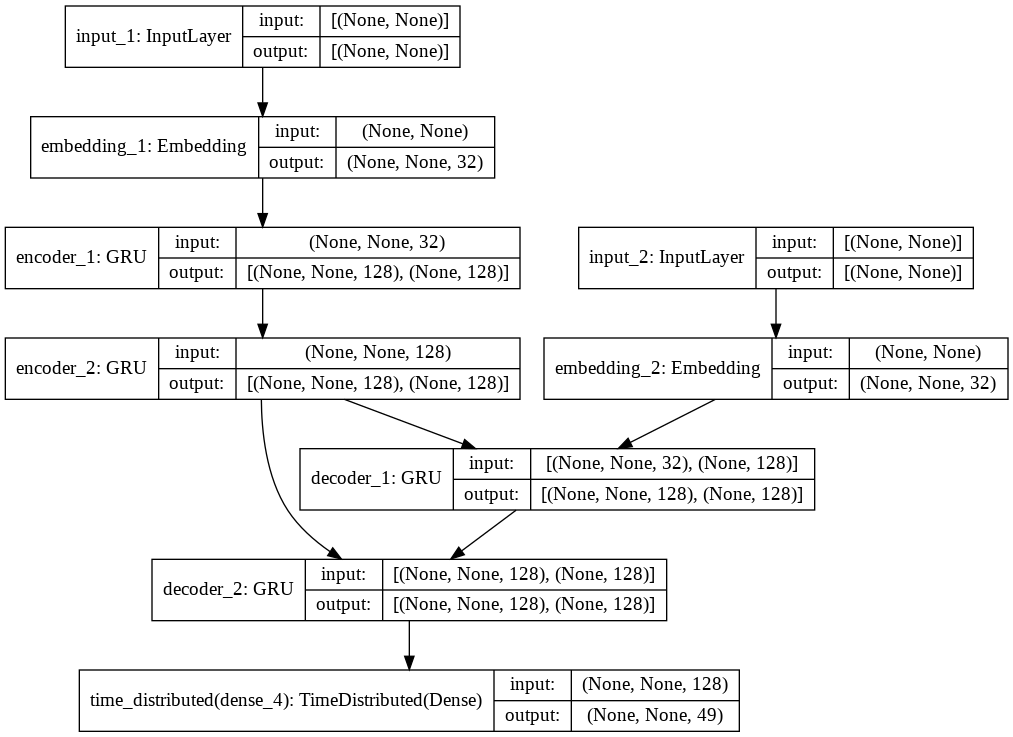

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 3 without Attention/1n2btank").name)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#plot_model(decoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

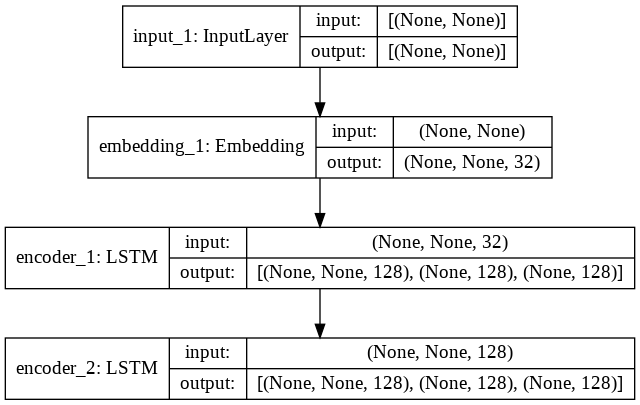

In [ ]:
plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 32)     864         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_1 (LSTM)                [(None, None, 128),  82432       embedding_1[0][0]                
____________________________________________________________________________________________

#OLD

In [ ]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
latent_dim = 128
encoder_inputs = model.input[0]  # input_1
encoder_seq,state_h_enc, state_c_enc  = model.get_layer('encoder_2').output
#encoder_seq,state_h_enc, state_c_enc = encoder_lstm2(encoder_seq)  # lstm_
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)


decoder_inputs = keras.Input(shape=(1,), name="input_2") # input_2
decoder_embed = model.get_layer('embedding_2')
decoder_input = decoder_embed(decoder_inputs)

decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm1 = model.get_layer('decoder_1')
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm1(
    decoder_input, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]

decoder_lstm2 = model.get_layer('decoder_2')
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm2(
    decoder_outputs,initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]


decoder_dense = model.get_layer('time_distributed')
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe5be06e7d0>> (for pre_run_cell):


Exception: ignored

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7fe5be06e7d0>> (for post_run_cell):


Exception: ignored

In [ ]:
states_value = encoder_model.predict(


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    #print(input_seq)
    states_value = encoder_model.predict([input_seq])
    #print(len(states_value))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        #print([target_seq] + states_value)
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]
        print(len(decoded_sentence))
    decoded_sentence = decoded_sentence.strip('\n')
    return decoded_sentence

In [ ]:
test_df[400:401]

,0,1,2
400,அவதாரங்களில்,avathaarangkalil,1


In [ ]:
decode_sequence(val_encoder_input_data[0:1])

1
2
3
4
5


'பிரா'

In [ ]:
def beam_search(input_seq, k):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((k, 1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[:, 0, 0] = target_token_index["\t"]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    sequences = [[list(), 0.0]]
    seq_len = 0
    #states = [np.zeros([k,1,32])] + [np.zeros([k,1,32])]
    h_s = np.zeros((k,1,32))
    c_s = np.zeros((k,1,32))
    while not stop_condition:
      all_candidates = list()
      seq_len += 1
      print(len(sequences))
      for i in range(len(sequences)):
        seq, score = sequences[i]
        for l in range(k):
          if i==0:
            output_tokens, h, c = decoder_model.predict([target_seq[l]] + states_value)    
          else:
            output_tokens, h, c = decoder_model.predict([target_seq[l]] + [h_s[l],c_s[l]])
          h_s[l] = h
          c_s[l] = c
          #states[l] = dec_states
          #output_tokens, h, c = decoder_model.predict([target_seq[l]] + states_value)
          #print(output_tokens.shape[2])
          for j in range(output_tokens.shape[2]):
            candidate = [seq + [j], score - log(output_tokens[0, -1, j])]
            #print(candidate)
            all_candidates.append(candidate)
        #print(all_candidates.shape)
        print(all_candidates)
        #order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        #print(ordered)
        indices = sorted(range(len(all_candidates)), key=lambda x: all_candidates[x])[:k]
        #print(indices)
        # select k best
        sequences = ordered[:k]
        target_seq = np.zeros((len(indices), 1, 1))
        
        for r in range(len(indices)):
          sampled_char = pred_target_token_index[indices[r]%49]
          target_seq[r, 0, 0] = indices[r]%49
          if sampled_char == "\n" or seq_len > max_decoder_seq_length:
              stop_condition = True
    return sequences

In [ ]:
beam_search(test_encoder_input_data[4000:4001], 3)

In [ ]:
test_results = model.predict([test_encoder_input_data,test_decoder_input_data])
test_pred = {}
for i in range(test_results.shape[0]):
  for j in range(26):
    if(j==0):
      test_pred[i] = pred_target_token_index[np.argmax(test_results[i],axis = 1)[j]]
    else:
      test_pred[i] = test_pred[i] + pred_target_token_index[np.argmax(test_results[i],axis = 1)[j]]
    #print(pred_target_token_index[np.argmax(test_results[i],axis = 1)[j]])
  test_pred[i] = test_pred[i].replace('\n', '')
  test_pred[i] = test_pred[i].replace(' ', '')

In [ ]:
test_print= {}
count =0;
for i in range(test_results.shape[0]):
  test_print[i] = [test_df[0][i],test_df[1][i],test_df[2][i],test_pred[i]]
  if(test_df[0][i]==test_pred[i]):
    count = count+1
    print(test_print[i])
print(count)

['அகத்தி', 'agaththi', 3, 'அகத்தி']
['அகத்தி', 'akaththi', 2, 'அகத்தி']
['அங்கீகரித்து', 'angkeegariththu', 1, 'அங்கீகரித்து']
['அங்கீகரித்து', 'angkeekariththu', 3, 'அங்கீகரித்து']
['அடக்கி', 'adakki', 3, 'அடக்கி']
['அடக்கிக்', 'adakkik', 3, 'அடக்கிக்']
['அடங்கிய', 'adangiya', 2, 'அடங்கிய']
['அடங்கிய', 'adankiya', 1, 'அடங்கிய']
['அடங்கியது', 'adanggiyadhu', 1, 'அடங்கியது']
['அடங்கியது', 'adanggiyathu', 1, 'அடங்கியது']
['அடங்கியது', 'adangiyadhu', 2, 'அடங்கியது']
['அடங்கியது', 'adangiyathu', 1, 'அடங்கியது']
['அடங்கியது', 'adankiyathu', 2, 'அடங்கியது']
['அடங்கியுள்ள', 'adangiyulla', 1, 'அடங்கியுள்ள']
['அடங்கியுள்ள', 'adangkiyulla', 2, 'அடங்கியுள்ள']
['அடங்கியுள்ள', 'adankiyuzhzha', 1, 'அடங்கியுள்ள']
['அடா', 'ada', 1, 'அடா']
['அடா', 'adaa', 1, 'அடா']
['அடிகளும்', 'adigalum', 2, 'அடிகளும்']
['அடிகளும்', 'adikalum', 2, 'அடிகளும்']
['அடிகளையும்', 'adigalaiyum', 1, 'அடிகளையும்']
['அடிகளையும்', 'adikalaiyum', 1, 'அடிகளையும்']
['அடிக்கடி', 'adikkadi', 3, 'அடிக்கடி']
['அடிக்கு', 'adikku', 3, 'அ

In [ ]:
loss0, accuracy0 = model.evaluate([test_encoder_input_data,test_decoder_input_data], test_decoder_target_data)

215/215 [==============================] - 3s 7ms/step - loss: 0.4231 - accuracy: 0.8713


In [ ]:
test_pred

In [ ]:
# beam search
def beam_search_decoder(data, k):
  sequences = [[list(), 0.0]]
  # walk over each step in sequence
  for row in data:
    all_candidates = list()
    # expand each current candidate
    for i in range(len(sequences)):
      seq, score = sequences[i]
      for j in range(len(row)):
        candidate = [seq + [j], score - log(row[j])]
        all_candidates.append(candidate)
    # order all candidates by score
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    # select k best
    sequences = ordered[:k]

  return sequences

In [ ]:
sequences = beam_search_decoder([test_encoder_input_data[4], test_decoder_input_data[4]],5)
print(sequences)

None


In [ ]:
def model_without_wandb(cell_name, embedding_size, hidden_size, num_enc_layers, num_dec_layers, dropout, batch_size, num_epochs, optimizer, r_dropout = 0.4):
  
  cell_type = { "RNN": keras.layers.SimpleRNN,
                "GRU": keras.layers.GRU,
                "LSTM": keras.layers.LSTM
  }

  learning_rate = 0.01
  decay_rate = 0

  optimizers = {"adam": tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate),
                "nadam": tf.keras.optimizers.Nadam(lr=learning_rate, decay=decay_rate),
                "rmsprop": tf.keras.optimizers.RMSprop(lr=learning_rate, decay=decay_rate),
                "adagrad": tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
  }

  # Define an input sequence and process it.
  encoder_inputs = keras.layers.Input(shape=(None,), name="input_1")
  embedding = keras.layers.Embedding(num_encoder_tokens, embedding_size, name="embedding_1")(encoder_inputs)
  encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_1") (embedding)
  for i in range(1, num_enc_layers):
    encoder_seq, *encoder_state = cell_type[cell_name](hidden_size, return_sequences=True,return_state = True, name="encoder_"+str(i+1), dropout=dropout, 
                                                       recurrent_dropout = r_dropout) (encoder_seq)

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = keras.Input(shape=(None,), name="input_2")
  decoder_embedding = keras.layers.Embedding(num_decoder_tokens, embedding_size, name="embedding_2")(decoder_inputs)

  # We set up our decoder to return full output sequences,
  # and to return internal states as well. We don't use the
  # return states in the training model, but we will use them in inference.
  decoder_seq, *_ = cell_type[cell_name](hidden_size,return_sequences=True, return_state=True, name="decoder_1")(decoder_embedding,initial_state=encoder_state)
  for i in range(1, num_dec_layers):
    decoder_seq, *_ = cell_type[cell_name](hidden_size, return_sequences=True, return_state=True, name="decoder_"+str(i+1),dropout=dropout,
                                           recurrent_dropout=r_dropout) (decoder_seq)

  decoder_outputs =keras.layers.Dense(num_decoder_tokens, activation="softmax", name="dense_1")(decoder_seq)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.compile(
    optimizer=optimizers[optimizer], loss="categorical_crossentropy", metrics=["accuracy"]
  )
  model.fit(
      [encoder_input_data, decoder_input_data],
      decoder_target_data,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_data=([val_encoder_input_data, val_decoder_input_data],
                      val_decoder_target_data)
  )

  model.save("s2s")
  return model

In [ ]:
def test(model):
#-----------MODEL EVALUATION WITH TEST DATA-------------------------------------
  wandb.init(project="Assignment-3")
  wandb.run.name = "Test_run_for_best_model"
  results = model.evaluate([test_encoder_input_data, test_decoder_input_data],
                      test_decoder_target_data,callbacks=[WandbCallback()])
  wandb.log({'test_loss': results[0], 'test_accuracy': results[1]})

In [ ]:
model = model_without_wandb("LSTM", 256, 64, 2, 2, 0.5, 512, 5, "rmsprop")

Epoch 1/5
117/134 [=========================>....] - ETA: 7s - loss: 1.3313 - accuracy: 0.6725

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("s2s")
wandb.init()
wandb.save('model-best.h5')

['/content/wandb/run-20210517_125715-2kx8p0pl/files/model-best.h5']

In [ ]:
model = keras.models.load_model("s2s")
model.summary()